## Simple Multi AI Agent Architecture (Independant agents)

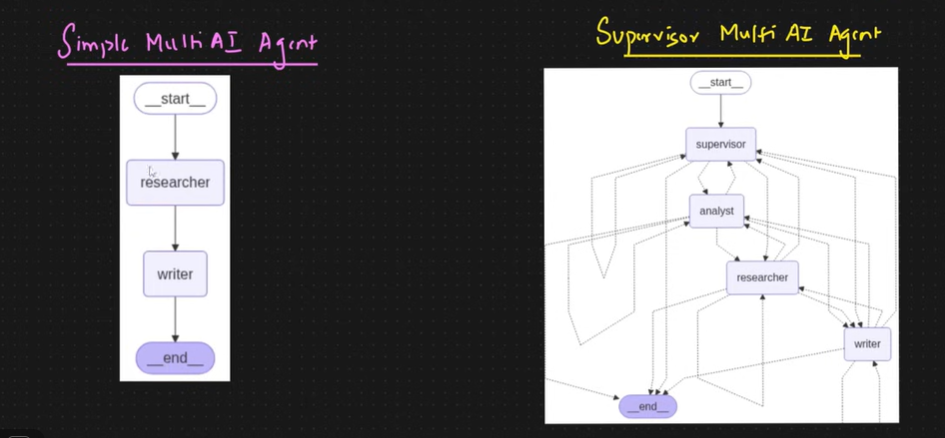

Here I am creating a Simple Multi agent 

1. Researcher Agent -> tavily search tool has to search the topic over the internet
2. Writer Agent is to take the input from the researcher agent and write the content

In [2]:
import os
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

In [4]:
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [ ]:
# Define the state
class AgentState(MessagesState):
    next_agent: str # which agent should go next

In [ ]:
# Create simple tools
# Researcher agent
@tool
def search_web(query:str) -> str:
    """Search the web for information"""
    # Using Tavily for web search
    search = TavilySearchResults(max_results=3)
    results = search.invoke(query)
    return str(results)


In [7]:
@tool
def write_summary(content: str)-> str:
    """Write a summary of the provided content"""
    # Simple summary generation
    summary = f'Summary of findings:\n\n{content[:500]}....'
    return summary

In [8]:
from langchain_groq import ChatGroq

llm = ChatGroq(model='llama-3.1-8b-instant')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F32905D970>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F328F58920>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [9]:
# Define researcher Agent

def researcher_agent(state: AgentState):
    """Researcher agent that searches for information"""

    messages = state['messages']

    # Add System message for context
    system_msg = SystemMessage(content="You are a research assistant. Use the search_web tool to find information about the user request")

    # Call LLM with Tools
    researcher_llm = llm.bind_tools([search_web])
    response = researcher_llm.invoke([system_msg] + messages)

    # Return the response and route to writer
    return {
        "messages": [response],
        "next_agent": "writer"
    }

In [10]:
def writer_agent(state: AgentState):
    """Writer agent that creates summaries"""

    messages = state['messages']

    # Add System Message
    system_msg = SystemMessage(content="You are a technical writer. review the conversation and create a clear, concise summary of the findings.")

    # SImple completion without tools
    response = llm.invoke([system_msg] + messages)

    return {
        "messages": [response],
        "next_agent": "end"
    }

In [11]:
# Tool executor node
def execute_tools(state: AgentState):
    """Execute any pending tool calls"""

    messages = state['messages']
    last_message = messages[-1]

    # Check if there are tool calls to execute
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        # Create tool node and execute
        tool_node = ToolNode([search_web, write_summary])
        response = tool_node.invoke(state)
        return response
    
    # No tools to execute
    return state

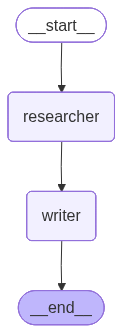

In [12]:
# Build graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("writer", writer_agent)

# Define flow
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", END)
final_workflow=workflow.compile()

final_workflow

In [13]:
response=final_workflow.invoke({"messages":"Reasearch about the usecase of agentic ai in business"})

In [14]:
response["messages"][-1].content

" \n\nBased on the search results, here's a summary of the findings:\n\n**Agentic AI in Business: Use Cases and Benefits**\n\nAgentic AI, also known as agent-based AI, is a type of artificial intelligence that enables systems to take autonomous actions on behalf of humans. In a business context, agentic AI can be used to automate routine tasks, improve decision-making, and enhance customer experience.\n\n**Common Use Cases for Agentic AI in Business**\n\n1. **Virtual Assistants**: Agentic AI can be used to create virtual assistants that can perform tasks such as scheduling appointments, sending emails, and making phone calls.\n2. **Chatbots**: Agentic AI-powered chatbots can be used to provide customer support, answer frequently asked questions, and help with sales and marketing.\n3. **Predictive Maintenance**: Agentic AI can be used to predict equipment failures, schedule maintenance, and reduce downtime.\n4. **Supply Chain Optimization**: Agentic AI can be used to optimize supply cha

- The disadvantage of this architecture is from researcher to Writer 
- from Writer to Researcher is can't go back
- what we can do is that, we can write a one more line from writer to Researcher, but it's not a efficient
- because this will be in a loop, either i can put a conditional edge and say that, this writer into a tool node and whenever there is a requirement we go ahead and basically execute this
- There are many disadvantages, so you can't develop a very efficient system by just using a simple multi agent architecture.
- So we are going to use a supervised multi agent architecture

## Supervised Multi AI Agent Architecture

Here we are going to create

- supervisor node : which will be having the control as soon as we get an input, it should be deciding whether we need to pass it to the *analyst* or the *researcher* or the *writer*

- let's say if i say hey supervisor you need to write arcticle on Agentic AI. The supervisor is basically it will directly give it to the writer or directly give it to the researcher will then probably go ahead and give it to writer for writing

- if supervisor says, Hey analyze this particular report and then u probably go ahead and write it for me right. So what will happen is

- Supervisor first needs to pass to the analyst and then analyst passes to the writer.

- We will try to create this kind of system where in supervisor can completely, here everybody dependant on the task that is provided by the supervisor, a very efficient way with respect to defining things right

In [15]:
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime

In [16]:
# ===================================
# State Definition
# ===================================

# ===================================
# State Definition
# ===================================

class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    next_agent: str = ""
    research_data: str = ""
    analysis: str = ""
    final_report: str = ""
    task_complete: bool = False
    current_task: str = ""

In [17]:
# ===================================
# Supervisor with Groq LLM
# ===================================
from langchain_core.prompts import ChatPromptTemplate
def create_supervisor_chain():
    """Creates the supervisor decision chain"""
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
1. Researcher - Gathers information and data
2. Analyst - Analyzes data and provides insights  
3. Writer - Creates reports and summaries

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has research data: {has_research}
- Has analysis: {has_analysis}
- Has report: {has_report}

Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
"""),
        ("human", "{task}")
    ])
    
    return supervisor_prompt | llm

In [18]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using Groq LLM"""
    
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    
    # Check what's been completed
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))
    
    # Get LLM decision
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })
    
    # Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)
    
    # Determine next agent
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: All tasks complete! Great work team."
    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "📋 Supervisor: Let's start with research. Assigning to Researcher..."
    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "📋 Supervisor: Research done. Time for analysis. Assigning to Analyst..."
    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "📋 Supervisor: Analysis complete. Let's create the report. Assigning to Writer..."
    else:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: Task seems complete."
    
    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

In [19]:
# ===================================
# Agent 1: Researcher (using Groq)
# ===================================

def researcher_agent(state: SupervisorState) -> Dict:
    """Researcher uses Groq to gather information"""
    
    task = state.get("current_task", "research topic")
    
    # Create research prompt
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""
    
    # Get research from LLM
    research_response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = research_response.content
    
    # Create agent message
    agent_message = f"🔍 Researcher: I've completed the research on '{task}'.\n\nKey findings:\n{research_data[:500]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": research_data,
        "next_agent": "supervisor"
    }

In [20]:
# ===================================
# Agent 2: Analyst (using Groq)
# ===================================

def analyst_agent(state: SupervisorState) -> Dict:
    """Analyst uses Groq to analyze the research"""
    
    research_data = state.get("research_data", "")
    task = state.get("current_task", "")
    
    # Create analysis prompt
    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

Research Data:
{research_data}

Provide:
1. Key insights and patterns
2. Strategic implications
3. Risks and opportunities
4. Recommendations

Focus on actionable insights related to: {task}"""
    
    # Get analysis from LLM
    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis = analysis_response.content
    
    # Create agent message
    agent_message = f"📊 Analyst: I've completed the analysis.\n\nTop insights:\n{analysis[:400]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }

In [21]:
# ===================================
# Agent 3: Writer (using Groq)
# ===================================

def writer_agent(state: SupervisorState) -> Dict:
    """Writer uses Groq to create final report"""
    
    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")
    
    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings  
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""
    
    # Get report from LLM
    report_response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = report_response.content
    
    # Create final formatted report
    final_report = f"""
📄 FINAL REPORT
{'='*50}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Topic: {task}
{'='*50}

{report}

{'='*50}
Report compiled by Multi-Agent AI System powered by Groq
"""
    
    return {
        "messages": [AIMessage(content=f"✍️ Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [22]:
# ===================================
# Router Function
# ===================================

def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """Routes to next agent based on state"""
    
    next_agent = state.get("next_agent", "supervisor")
    
    if next_agent == "end" or state.get("task_complete", False):
        return END
        
    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent
        
    return "supervisor"

In [23]:
# Create workflow
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)

# Set entry point
workflow.set_entry_point("supervisor")

# Add routing
for node in ["supervisor", "researcher", "analyst", "writer"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            END: END
        }
    )

graph=workflow.compile()

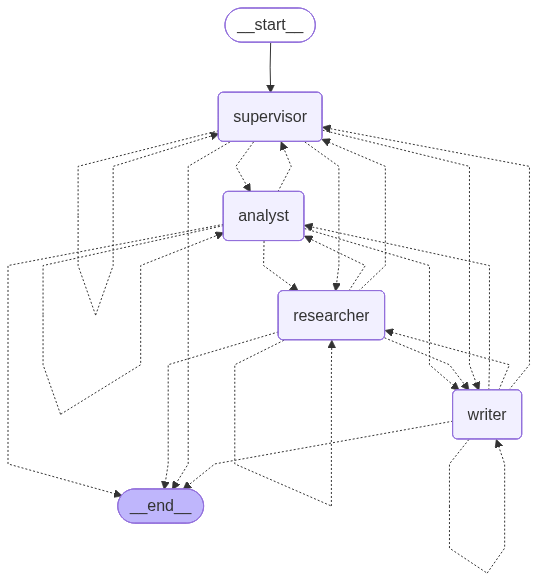

In [24]:
graph

In [25]:
response=graph.invoke(HumanMessage(content="What are the benefits and risks of AI in healthcare?"))

researcher
analyst
writer


In [29]:
response['final_report']

"\n📄 FINAL REPORT\n==================================================\nGenerated: 2025-11-17 19:07\nTopic: 📊 Analyst: I've completed the analysis.\n\nTop insights:\nIt seems we have a circular situation here.  Since there's no specific topic provided for research, I'll suggest a hypothetical topic to work with. Let's consider 'The Impact of Remote Work on Employee Productivity.'\n\nAssuming this topic, I'll provide the required analysis:\n\n**Key Facts and Background:**\n\n- Remote work has been on the rise since the COVID-19 pandemic, with many companies adopting ...\n==================================================\n\n**Executive Report: The Impact of Remote Work on Employee Productivity**\n\n**Executive Summary:**\n\nThis report provides an analysis of the impact of remote work on employee productivity, a critical aspect of modern work environments. Our research findings highlight the complexities and nuances of remote work, which can have both positive and negative effects on emp

""" Simple Hierarchical Multi-Agent System with Groq
Shows how to organize agents in teams with team leaders."""

### Structure:

-CEO (top level)
- Research Team Leader
    -  Data Researcher
    -  Market Researcher
-Writing Team Leader
    -Technical Writer
    -Summary Writer